In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [3]:
class CrossOverBacktest:
    '''
    This package implements the Cross Over Strategy. There are 4 main methods:
    1. constructors
    2. handle data
    3. Backtest
    4. get results

    - input: capital, start_date, end_date, ticker, stock_series, short_term_trend, long_term_trend
    - output: return a dataframe with stock series, portfolio value, share held and holdings
    '''

    def __init__(self,capital, start_date,end_date,ticker,stock_series,short_term_trend,long_term_trend):

        # DataFrames to store our profits and shares held
        self.profits_df = None
        self.shares_df = None

        # input:
        self.capital = capital
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.stock_series = stock_series
        self.short_trend = short_term_trend
        self.long_trend = long_term_trend

        # we need a counter method to keep track the type if trades: losses or wins
        self.count_profit = 0
        self.count_loss = 0
        self.count_trade = 0

        # keep track of average
        self.avg_pos_trade = None
        self.avg_neg_trade = None
        self.avg_trade_val = None

        # keep track of individual trades, stock them in lists
        self.profit = []
        self.holdings = []
        self.invested = []

        # keep track of portfolio value
        self.portfolio_value = None
        self.shares = None

        # DataFrame for price and performance
        self.prices_df = pd.DataFrame()
        self.results = None
        self.return_performance = None

        # keep track of essential price
        self.open_price = None
        self.close_price = None
        self.profit_df = None

    def handle_data(self,plot=False):
        # create signals based on start and long term trend
        self.prices_df['stock_price'] = self.stock_series
        self.prices_df['short_trend'] = self.stock_series.rolling(self.short_trend).mean()
        self.prices_df['long_trend'] = self.stock_series.rolling(self.long_trend).mean()

        self.prices_df['position_open'] = np.where(self.prices_df.short_trend>self.prices_df.long_trend,1,0)

        self.prices_df['trade_open'] = self.prices_df['position_open'].diff()

        self.open_price = self.prices_df['stock_price'][self.prices_df['trade_open'] == 1]
        self.close_price = self.prices_df['stock_price'][self.prices_df['trade_open'] == -1]

        if len(self.open_price) > len(self.close_price):

            last_trade_day = self.prices_df.index[-1]
            self.prices_df['positions_open'].loc[last_trade_day] = -1
            self.prices_df['trade_open'].loc[last_trade_day] = -1
            self.close_price.loc[last_trade_day] = self.prices_df['stock_price'].loc[last_trade_day]
            self.profit_df = pd.DataFrame(self.close_price.values - self.open_price.values, index=self.close_price.index)

        elif len(self.open_price) == len(self.close_price):
            self.profit_df = pd.DataFrame(self.close_price.values - self.open_price.values, index=self.close_price.index)

        if plot:
            plt.figure(figsize=(12, 8))

            # Plot the closing price
            plt.plot(self.prices_df['stock_price'], color='black', lw=2.)

            # Plot the short and long moving averages
            plt.plot(self.prices_df[['short_trend', 'long_trend']], lw=2.)

            plt.plot(self.prices_df['stock_price'][self.prices_df['trade_open'] == 1], '^', markersize=8, color='m', label='buy signal')
            plt.plot(self.prices_df['stock_price'][self.prices_df['trade_open'] == -1], 'v', markersize=8, color='k', label='sell signal')
            plt.legend(['price', 'MA_'+str(self.short_trend), 'MA_'+str(self.long_trend), 'Buy Signal', 'Sell Signal'], loc='best')
            plt.show()

    def backtest(self):
        # keep track of the shares and every new portfolio position for every trade done
        self.shares = np.zeros(len(self.open_price))
        self.portfolio_value = np.zeros(len(self.open_price))
        
        # place the first trade
        self.count_trade += 1
        self.shares[0] = int(math.floor(self.capital / self.open_price.iloc[0]))
        actual_investment = self.shares[0] * self.open_price.iloc[0]
        holding = self.capital - actual_investment
        
        # close first trade
        profit_per_trade = round(float(self.shares[0] * self.profit_df.iloc[0]),4)
        if profit_per_trade > 0:
            self.count_profit += 1
            
        self.portfolio_value[0] = profit_per_trade + holding + actual_investment
        
        # Keep track of measures of interest:
        self.holdings.append(holding)
        self.profit.append(profit_per_trade)
        self.invested.append(actual_investment)
        
        # loop over all the other positions we have taken
        for i in range(1, len(self.open_price)):
            # place trade:
            self.count_trade += 1
            self.shares[i] = int(math.floor(self.portfolio_value[i-1] / self.open_price.iloc[i]))
            actual_investment = self.shares[i] * self.open_price.iloc[i]
            holding = self.portfolio_value[i-1] - actual_investment

            # close trade:
            profit_per_trade = round(float(self.shares[i] * self.profit_df.iloc[i]), 4)
            if profit_per_trade > 0:
                self.count_profit += 1
            else:
                self.count_loss += 1
                
            # update the results
            self.portfolio_value[i] = profit_per_trade + holding + actual_investment
            self.holdings.append(holding)
            self.profit.append(profit_per_trade)
            self.invested.append(actual_investment)

    def get_results(self):
        
        self.profits_df = pd.DataFrame(self.profit, columns=['profit_from_trade'])
        port_val_df = pd.DataFrame(self.portfolio_value, index=self.close_price.index, columns=['portfolio_value']).reindex(index=self.prices_df.index)
        self.shares_df = pd.DataFrame(self.shares, index=self.open_price.index, columns=['shares']).reindex(index=self.prices_df.index)
        holding_df = pd.DataFrame(self.holdings, index=self.open_price.index, columns=['holdings']).reindex(index=self.prices_df.index)

        # concatenating them together
        self.results = pd.concat([port_val_df, self.shares_df, holding_df, self.prices_df], sort=True, axis=1)
        
        # if we are not trading on our first day
        if math.isnan(self.results.shares.iloc[0]):
            self.results.shares.iloc[0] = 0
            self.results.holdings.iloc[0] = 0
            self.results.portfolio_value.loc[:self.open_price.index[0]] = self.capital
            
        # if we are trading on our first day
        self.results.shares.fillna(method='ffill', inplace=True)
        self.results.holdings.fillna(method='ffill', inplace=True)
        
        # portfolio_value = shares * stock_price + what ever we are holding
        self.results.portfolio_value = self.results.portfolio_value.fillna(self.results.shares * self.results.stock_price)
        self.results.portfolio_value = self.results.portfolio_value + self.results.holdings
        
        self.avg_trade_val = self.profits_df.profit_from_trade.mean()
        self.avg_pos_trade = self.profits_df.profit_from_trade[self.profits_df.profit_from_trade > 0].mean()
        self.avg_neg_trade = self.profits_df.profit_from_trade[self.profits_df.profit_from_trade < 0].mean()

In [4]:
ticker = 'TSLA'
start = '2022-05-01'
end = '2023-05-01'
capital = 100000
long_ma = 13
short_ma = 5

df = yf.download(ticker,start=start,end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-02,286.923340,302.119995,282.676666,300.980011,300.980011,75781500
2022-05-03,301.059998,308.026672,296.196655,303.083344,303.083344,63709500
2022-05-04,301.313324,318.500000,295.093323,317.540009,317.540009,81643800
2022-05-05,313.006653,315.200012,285.899994,291.093323,291.093323,92519100
2022-05-06,295.666656,296.000000,281.036682,288.549988,288.549988,72903000
...,...,...,...,...,...,...
2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600
2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300
2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100


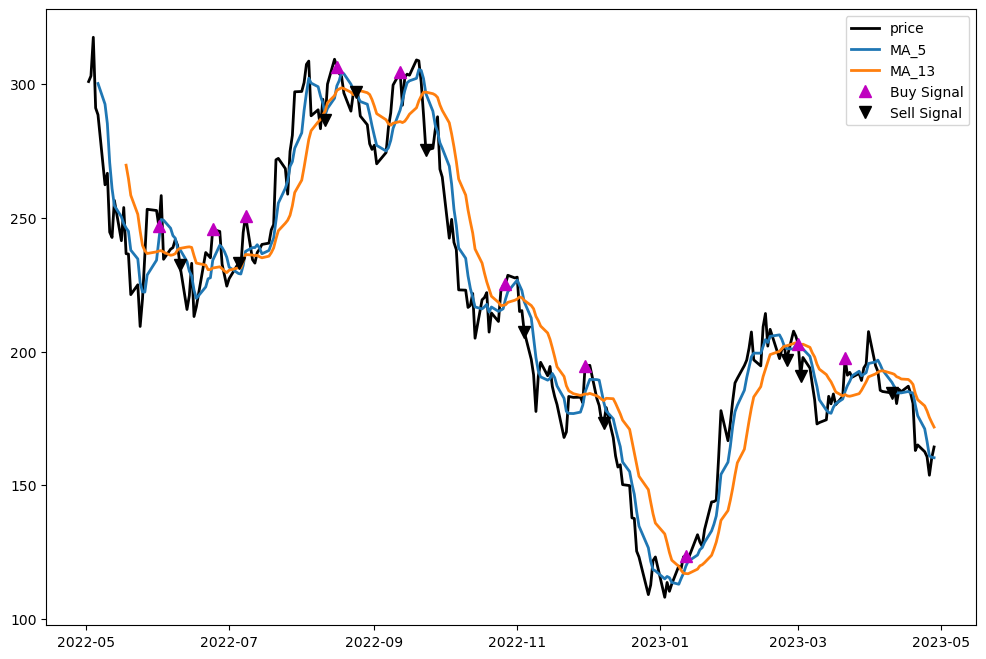

In [6]:
trial_tesla = CrossOverBacktest(start_date=start, end_date=end, ticker=ticker,
                                capital=capital, short_term_trend=short_ma, long_term_trend=long_ma,
                                stock_series=df['Adj Close'])

trial_tesla.handle_data(plot=True)

In [7]:
trial_tesla.backtest()
trial_tesla.get_results()

In [8]:
trial_tesla.results

,portfolio_value,shares,holdings,stock_price,short_trend,long_trend,position_open,trade_open
Date,,,,,,,,
2022-05-02,100000.00000,0.0,0.00000,300.980011,NaN,NaN,0,NaN
2022-05-03,100000.00000,0.0,0.00000,303.083344,NaN,NaN,0,0.0
2022-05-04,100000.00000,0.0,0.00000,317.540009,NaN,NaN,0,0.0
2022-05-05,100000.00000,0.0,0.00000,291.093323,NaN,NaN,0,0.0
2022-05-06,100000.00000,0.0,0.00000,288.549988,300.249335,NaN,0,0.0
...,...,...,...,...,...,...,...,...
2023-04-24,90678.42398,557.0,138.07228,162.550003,171.104001,179.683075,0,0.0
2023-04-25,89631.26126,557.0,138.07228,160.669998,166.376001,177.771536,0,0.0
2023-04-26,85776.82228,557.0,138.07228,153.750000,161.008002,175.363075,0,0.0


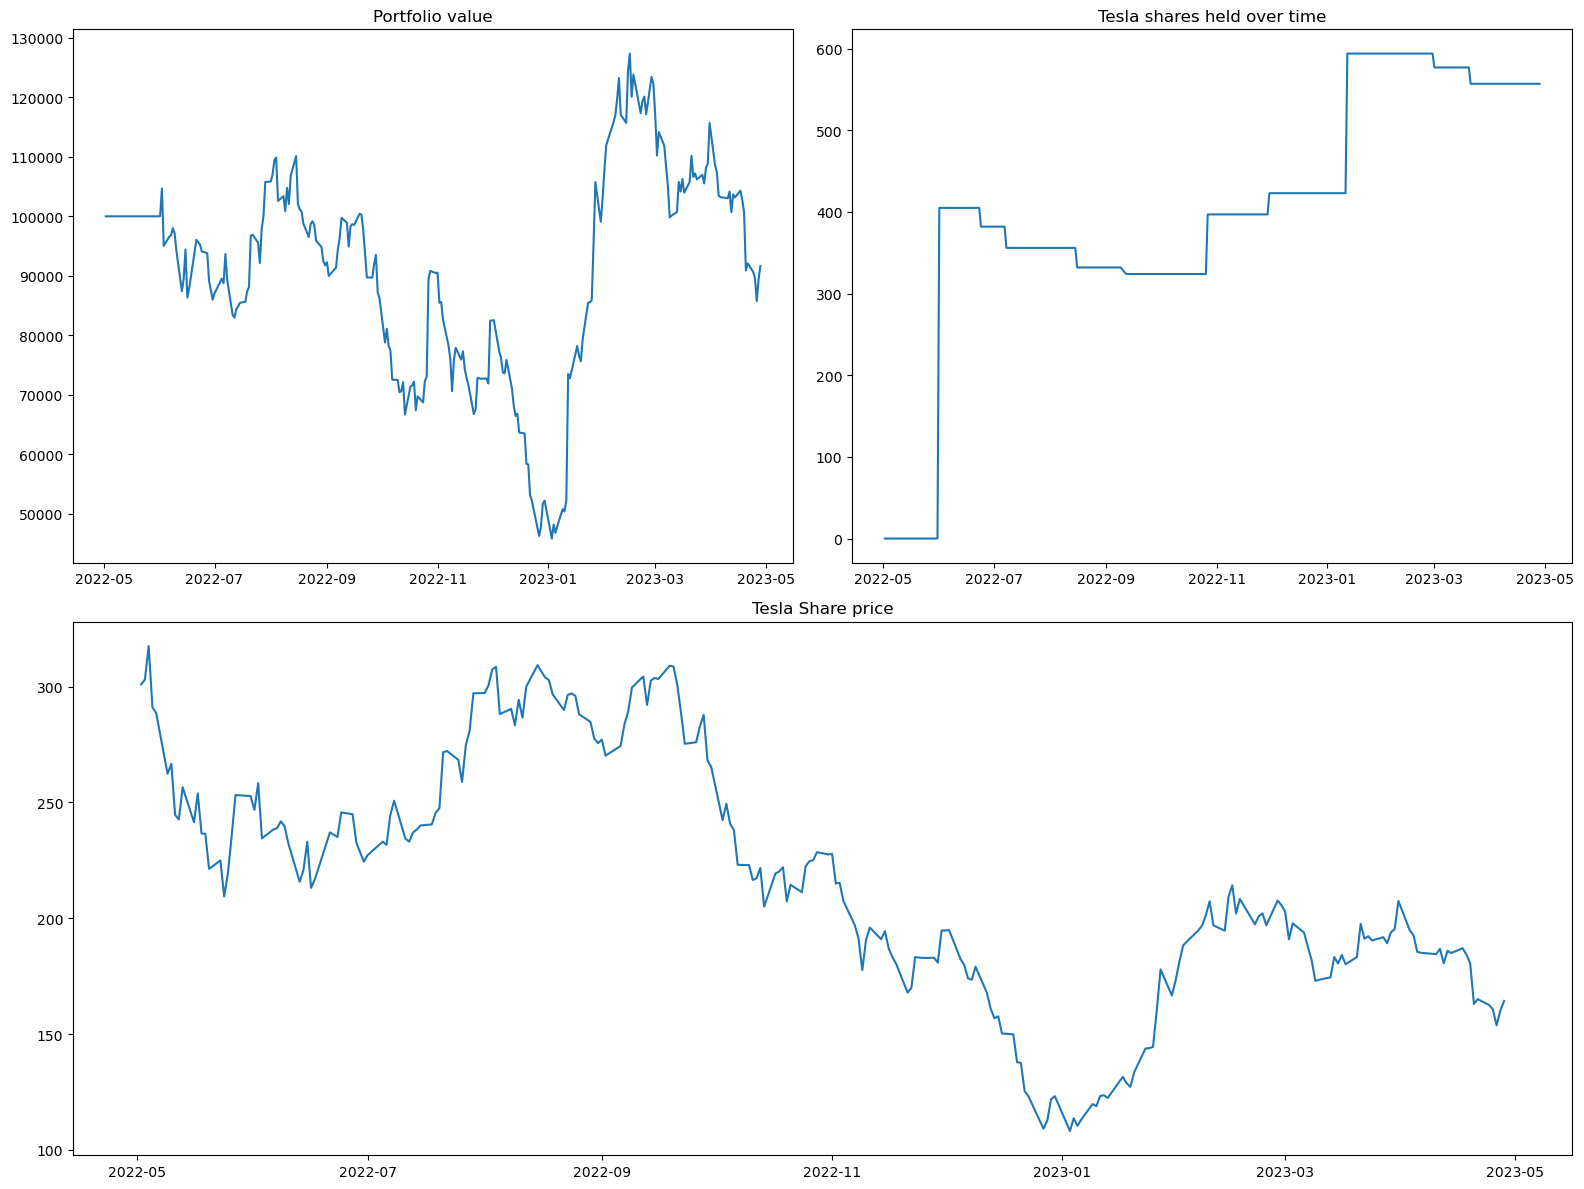

In [9]:
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(2, 2, 1)

ax1.plot(trial_tesla.results.portfolio_value)
ax1.set_title('Portfolio value')

ax2 = plt.subplot(2, 2, 2)
ax2.plot(trial_tesla.results.shares)
ax2.set_title('Tesla shares held over time')

ax3 = plt.subplot(2, 1, 2)
ax3.plot(trial_tesla.results.stock_price)
ax3.set_title('Tesla Share price')

plt.tight_layout()
plt.show()

In [10]:
print('Average loss from the strategy: ',trial_tesla.avg_neg_trade)
print('Average profit from the strategy: ',trial_tesla.avg_pos_trade)
print('Average position: ',trial_tesla.avg_trade_val)
print('Number of positive trades: ',trial_tesla.count_profit)
print('Number of negative trades: ',trial_tesla.count_loss)
print('Number of total trades: ',trial_tesla.count_trade)
print('success ratio: ',trial_tesla.count_profit/trial_tesla.count_trade)

Average loss from the strategy:  -6676.3099125
Average profit from the strategy:  28160.30925
Average position:  291.0139200000009
Number of positive trades:  2
Number of negative trades:  7
Number of total trades:  10
success ratio:  0.2
